In [1]:
!pip install pyspark
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 53 kB/s 
     |████████████████████████████████| 199 kB 86.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=df37796042b3128fedef401ee4281f2f9ca32ca67755fb875a83616454c5315a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
drive  sample_data


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import countDistinct, isnan, when
from pyspark.sql.functions import col, count
from pyspark.sql.functions import hour, month, year, to_timestamp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, max, min


from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression 
from pyspark.ml.evaluation import RegressionEvaluator


import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [4]:
#create a Spark Session with Google Cloud connector
spark = SparkSession \
    .builder \
    .appName("GCS_NASA") \
    .config("spark.jars", "drive/Shareddrives/Big_Data_and_BI/connector/gcs-connector-hadoop3-latest.jar") \
    .getOrCreate()


# Setup hadoop fs configuration for schema gs://
conf = spark.sparkContext._jsc.hadoopConfiguration()
conf.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
conf.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

# Google Cloud Authentication
conf.set("fs.gs.auth.type", "SERVICE_ACCOUNT_JSON_KEYFILE")
conf.set("fs.gs.auth.service.account.json.keyfile","drive/Shareddrives/Big_Data_and_BI/key/secrets.json")

for item in SparkConf().getAll(): print(item)
print(conf)
df=spark.read.csv("drive/Shareddrives/Big_Data_and_BI/key/secrets.json", sep=',', inferSchema=True, header=True)



('spark.app.submitTime', '1670763801637')
('spark.app.name', 'GCS_NASA')
('spark.master', 'local[*]')
('spark.submit.pyFiles', '')
('spark.repl.local.jars', 'file:///content/drive/Shareddrives/Big_Data_and_BI/connector/gcs-connector-hadoop3-latest.jar')
('spark.submit.deployMode', 'client')
('spark.jars', 'file:///content/drive/Shareddrives/Big_Data_and_BI/connector/gcs-connector-hadoop3-latest.jar')
('spark.ui.showConsoleProgress', 'true')
Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-rbf-default.xml, hdfs-site.xml, hdfs-rbf-site.xml, __spark_hadoop_conf__.xml


# Meta-data

In [5]:
bucket_name="nasa_bucket"
path=f"gs://{bucket_name}/asteroid/Asteroid_Updated.csv"
#path= "drive/Shareddrives/Big_Data_and_BI/data/NASA/Asteroid_Updated.csv"

df=spark.read.csv(path, sep=',', inferSchema=True, header=True)

In [6]:
print(f"Total records: {df.count()}")
df.show(20)

Total records: 1260411
+--------------------+------+-----+-----+-----+------+------+------+----+------+------+-----+-----+-----+--------+----------+--------------+---+---+----+----+--------+--------------------+------+----------+---------+-----+-----+----+------+------+
|           full_name|     e|    a|    q|    i|    om|     w|    ma|  ad|     n|   per|per_y| moid|class|data_arc|n_obs_used|condition_code|neo|pha|   H|   G|diameter|              extent|albedo|   rot_per|       GM|   BV|   UB|  IR|spec_B|spec_T|
+--------------------+------+-----+-----+-----+------+------+------+----+------+------+-----+-----+-----+--------+----------+--------------+---+---+----+----+--------+--------------------+------+----------+---------+-----+-----+----+------+------+
|     1 Ceres (A80...|0.0788|2.767|2.549|10.59| 80.26| 73.47| 17.22|2.99|0.2141|1680.0|  4.6| 1.58|  MBA|    9520|      1075|             0|  N|  N|3.33|0.12|   939.4|964.4 x 964.2 x 8...|  0.09|   9.07417|  62.6284|0.713|0.426|null|

In [7]:
print (f"{len(df.columns)} fields") 
df.printSchema()

31 fields
root
 |-- full_name: string (nullable = true)
 |-- e: double (nullable = true)
 |-- a: double (nullable = true)
 |-- q: double (nullable = true)
 |-- i: double (nullable = true)
 |-- om: double (nullable = true)
 |-- w: double (nullable = true)
 |-- ma: double (nullable = true)
 |-- ad: double (nullable = true)
 |-- n: double (nullable = true)
 |-- per: double (nullable = true)
 |-- per_y: double (nullable = true)
 |-- moid: double (nullable = true)
 |-- class: string (nullable = true)
 |-- data_arc: integer (nullable = true)
 |-- n_obs_used: integer (nullable = true)
 |-- condition_code: string (nullable = true)
 |-- neo: string (nullable = true)
 |-- pha: string (nullable = true)
 |-- H: double (nullable = true)
 |-- G: double (nullable = true)
 |-- diameter: double (nullable = true)
 |-- extent: string (nullable = true)
 |-- albedo: double (nullable = true)
 |-- rot_per: double (nullable = true)
 |-- GM: double (nullable = true)
 |-- BV: double (nullable = true)
 |-- UB: d

In [8]:
#user_order.select([count(when((isnan(c) | col(c).isNull()), c)).alias(c) for c in user_order.columns]).show()
#[count(when(isnan(c) | col(c).isNull(), c)) for c in user_order.columns]

# Data Processing

In [9]:
astro_df = df.dropna(subset=['diameter'])
drop_list = ["extent", 
           "rot_per", 
           "GM", "BV", "UB", "IR", 
           "spec_B",
           "spec_T", 
           "G", 'data_arc', 'H', 'albedo']
astro_df = astro_df.drop(*drop_list)

In [10]:
astro_df.show(5)

+--------------------+------+-----+-----+-----+------+------+------+----+------+------+-----+----+-----+----------+--------------+---+---+--------+
|           full_name|     e|    a|    q|    i|    om|     w|    ma|  ad|     n|   per|per_y|moid|class|n_obs_used|condition_code|neo|pha|diameter|
+--------------------+------+-----+-----+-----+------+------+------+----+------+------+-----+----+-----+----------+--------------+---+---+--------+
|     1 Ceres (A80...|0.0788|2.767|2.549|10.59| 80.26| 73.47| 17.22|2.99|0.2141|1680.0|  4.6|1.58|  MBA|      1075|             0|  N|  N|   939.4|
|     2 Pallas (A8...|0.2301| 2.77|2.132|34.93|172.92|310.86|357.85|3.41|0.2138|1680.0| 4.61|1.23|  MBA|      9046|             0|  N|  N|   513.0|
|     3 Juno (A804...|0.2565| 2.67|1.985|12.99|169.84|247.74|351.82|3.35|0.2259|1590.0| 4.36|1.04|  MBA|      7410|             0|  N|  N| 246.596|
|     4 Vesta (A80...|0.0888|2.363|2.153| 7.14|103.76| 151.6|115.13|2.57|0.2713|1330.0| 3.63|1.14|  MBA|      94

# Data Visualization

## Bar Chart for asteroid diameter

In [12]:
astro_df.agg(min(col("diameter")), max(col("diameter"))).show()

+-------------+-------------+
|min(diameter)|max(diameter)|
+-------------+-------------+
|       0.0025|        939.4|
+-------------+-------------+



In [36]:
count_list = []
label = []
for i in range (0, 10, 2):
  count_list += [astro_df.filter( (col("diameter") > (i)) & (col("diameter") < (i+ 2)) ).count()]
  label += [f"{i} - {i + 2}"]

for i in range (10, 50, 10):
  count_list += [astro_df.filter( (col("diameter") > (i)) & (col("diameter") < (i+ 10)) ).count()]
  label += [f"{i} - {i + 10}"]

for i in range (50, 200, 50):
  count_list += [astro_df.filter( (col("diameter") > (i)) & (col("diameter") < (i+ 50)) ).count()]
  label += [f"{i} - {i + 50}"]

for i in range (200, 1000, 400):
  count_list += [astro_df.filter( (col("diameter") > (i)) & (col("diameter") < (i+ 400)) ).count()]
  label += [f"{i} - {i + 400}"]

diameter_data = {'label': label, 'data': count_list}
diameter_df = pd.DataFrame(data=diameter_data)
diameter_df


,label,data
0,0 - 2,13582
1,2 - 4,57586
2,4 - 6,36981
3,6 - 8,15272
4,8 - 10,6098
5,10 - 20,7500
6,20 - 30,1212
7,30 - 40,469
8,40 - 50,236
9,50 - 100,527


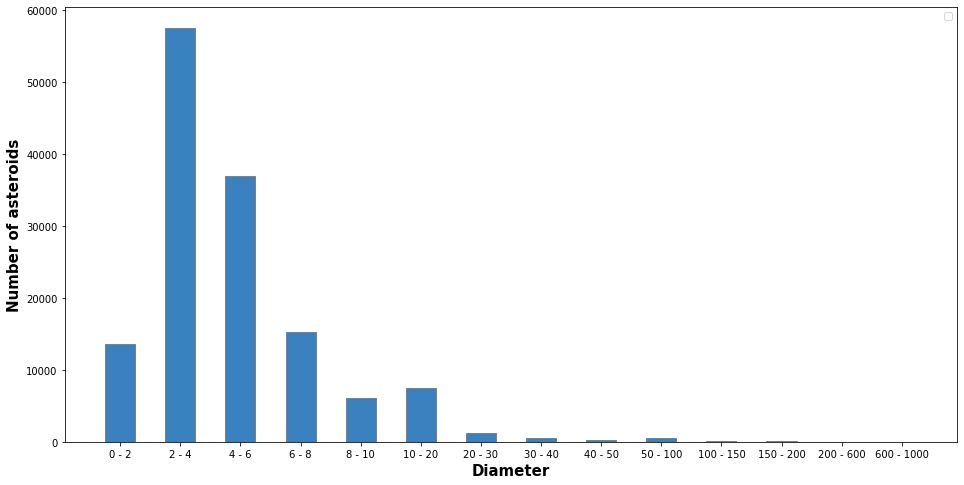

In [41]:
# set width of bar
barWidth = 0.5
fig = plt.subplots(figsize =(16, 8))
 
# Set position of bar on X axis
X_axis = np.arange(len(diameter_df["label"]))
 
# Make the plot
count = 0
color_list = ["#3981BF", "#38A649", "#F2AE30", "#F2594B", "#F2594C"]

plt.bar(X_axis + barWidth*(0.5+ count), diameter_df["data"], color = color_list[count], width = barWidth,
        edgecolor ='grey')


 
# Adding Xticks
plt.xlabel('Diameter', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of asteroids', fontweight ='bold', fontsize = 15)
plt.xticks(X_axis + 0.5*barWidth,diameter_df["label"])
 
plt.legend()
plt.show()

In [50]:
class_list = [x for y in astro_df.select("class").distinct().toPandas().values for x in y]
print(class_list)

['OMB', 'ATE', 'TJN', 'APO', 'AST', 'TNO', 'IMB', 'MCA', 'AMO', 'CEN', 'MBA', 'JFc', 'JFC', 'COM', 'HTC', 'CTc', 'ETc']


In [62]:
avrg_pd = astro_df.groupBy(col("class")).agg( avg(col("diameter")).alias("average")).toPandas()
#avrg_pd

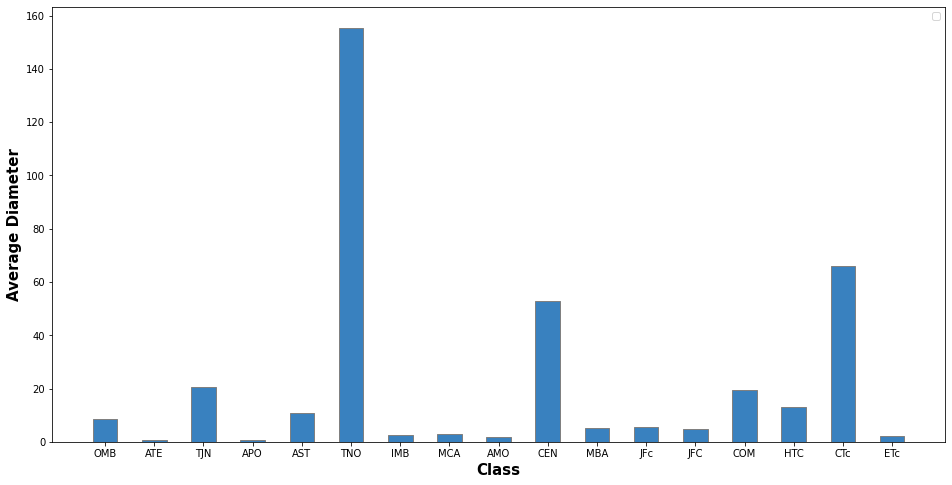

In [63]:
# set width of bar
barWidth = 0.5
fig = plt.subplots(figsize =(16, 8))
 
# Set position of bar on X axis
X_axis = np.arange(len(avrg_pd["class"]))
 
# Make the plot
count = 0

plt.bar(X_axis + barWidth*(0.5+ count), avrg_pd["average"], color = "#3981BF", width = barWidth,
        edgecolor ='grey')


 
# Adding Xticks
plt.xlabel('Class', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Diameter', fontweight ='bold', fontsize = 15)
plt.xticks(X_axis + 0.5*barWidth,avrg_pd["class"])
 
plt.legend()
plt.show()